

<h1 align="center"> Anti-Cancer Drug Activity Prediction </h1>
<h2 align="center"> competition #5 </h2>


---



---


# **Name:**  Sandra Girgis
# **ID:** 20399121

# ⭐ Problem Statement

☘️ Anti-Cancer Drug Activity Prediction is a task in the field of drug discovery that involves predicting the effectiveness of a given compound in inhibiting the growth of cancer cells or inducing cancer cell death. The problem statement of this task is to develop a machine learning model that can accurately predict the activity of new compounds against a specific type of cancer or multiple types of cancer.


👉🏻 So, **The problem statement** and the goal of Anti-Cancer Drug Activity Prediction is to identify promising drug candidates that can be further developed and tested in preclinical and clinical trials, ultimately leading to the discovery of new cancer therapies. Accurate prediction of drug activity can save time and resources in the drug discovery process by allowing researchers to focus on the most promising candidates and avoid less effective or toxic compounds.

### ⭐ The input of the project:
👉🏻 A large set of chemical compounds, represented by their molecular structures and various features or descriptors, such as physicochemical properties, functional groups, and substructures.



### ⭐ The output of the project:
👉🏻 The predicted activity score or label for each compound, indicating its potential effectiveness in treating cancer.




### ⭐ The required data mining functions of the project:
 
🔥 Participants are required to build a Graph Convolutional Network **(GCN)** model to predict the activity of different compounds against a specific type of cancer or multiple types of cancer. The input to the model consists of a large set of chemical compounds, represented by their molecular structures and various features or descriptors. The output is a predicted activity score or label for each compound, indicating its potential effectiveness in treating cancer.

🔥 Using some of **message passing** mechanisms such as **GGNN, RGCN, RGAT, GNN-FILM**

🔥 **Classification** is a common data mining function that involves predicting the class or category of a given data point based on its features or attributes. In this case, the goal is to classify compounds as active or inactive against cancer cells based on their molecular features, which is a typical use case for classification in data mining.




##⭐ **The impact of this project an be significant in several ways:** 
🔥 Accelerating drug discovery: The traditional drug discovery process can be very time-consuming and expensive, with high failure rates. By accurately predicting the activity of different compounds against cancer cells, the Anti-Cancer Drug Activity Prediction task can help accelerate the drug discovery process by identifying promising drug candidates early in the process, potentially reducing the time and resources required for drug development.

🔥 Reducing animal testing: The Anti-Cancer Drug Activity Prediction task can also help reduce the need for animal testing in drug development, which can be expensive and time-consuming, as well as controversial from an ethical standpoint.

🔥 Advancing machine learning techniques: The development of machine learning models for drug discovery can help advance the field of machine learning and artificial intelligence, as well as the broader field of data science.

</br>
</br>

<p align = "center"> So let's work on the data that we have to see what this problem leads us to do and what is the accurate solution....😃</p>

# Part I) Preparing Data

## I.I) Read SDF format data (structured-data format)

In [19]:
import numpy as np
from tqdm.notebook import tqdm

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                
        
        

In [2]:
# training_set = read_sdf('/content/train.sdf')

## I.II) Oversample Impalanced Data

In [3]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler


training_set = np.array(read_sdf('/content/train.sdf'),dtype=object)


#save input features to variable
input = training_set[:,0:-1]
#save output features to another variable
output = training_set[:,-1]
#convert the data type of output feature to integer
output = output.astype('int8')
print(output)
#count the number of 0 and 1 in this data set
print(Counter(output))

#start random over sampling by increase the samples that has labels of 1
oversample = RandomOverSampler(sampling_strategy='minority')
input,output = oversample.fit_resample(input,output)

#reshape the output
output = output.reshape(len(output),1)

#concate the input with output to the training dataset
training_set = np.append(input, output, axis=1)
print(Counter(training_set[:,-1]))

  0%|          | 0/25024 [00:00<?, ?it/s]

[0 0 0 ... 0 0 0]
Counter({0: 23806, 1: 1218})
Counter({0: 23806, 1: 23806})


In [4]:
from sklearn.model_selection import train_test_split
#split the training dataset to training and validation dataset
training_set, validation_set = train_test_split(training_set, test_size=0.15,stratify = training_set[:,-1],)
print(training_set.shape)

(40470, 3)


In [5]:
testing_set  = read_sdf('/content/test_x.sdf')
print(len(testing_set))

  0%|          | 0/12326 [00:00<?, ?it/s]

12326


In [6]:
print(training_set[5])

[list(['Cl', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'])
 array([[ 0, 12],
        [ 1,  4],
        [ 1, 11],
        [ 2,  3],
        [ 2,  4],
        [ 2,  6],
        [ 3,  5],
        [ 3,  7],
        [ 4,  9],
        [ 5, 10],
        [ 6, 13],
        [ 7, 11],
        [ 8, 10],
        [ 8, 12],
        [ 8, 15],
        [ 9, 14],
        [12, 16],
        [13, 14],
        [15, 17],
        [16, 18],
        [17, 18]]) 0]


## I.III) Visualizing/Inspecting a Sample

In [7]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [8]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

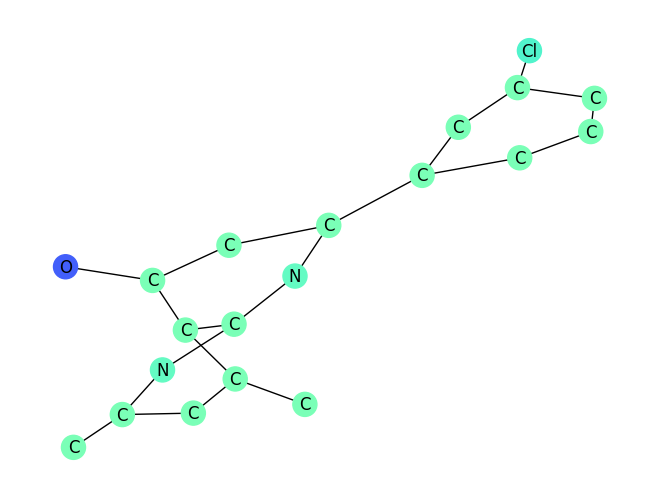

In [9]:
plt.clf()
visualize(training_set[20])

# Part II) Preprocessing Data

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [12]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[4 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 2 3 3 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 5 5 6 2 2 2 3 3 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0]
edges
[[  0  28]
 [  1   6]
 [  2   7]
 [  3   4]
 [  3  10]
 [  4  28]
 [  5  28]
 [  6   7]
 [  6  13]
 [  6  14]
 [  7   8]
 [  8   9]
 [  8  18]
 [  9  16]
 [  9  21]
 [ 10  11]
 [ 10  12]
 [ 11  17]
 [ 11  19]
 [ 12  15]
 [ 12  22]
 [ 13  16]
 [ 14  17]
 [ 15  20]
 [ 15  23]
 [ 18  24]
 [ 19  20]
 [ 21  25]
 [ 22  26]
 [ 23  27]
 [ 24  25]
 [ 26  27]
 [ 29  49]
 [ 30  39]
 [ 31  36]
 [ 31  39]
 [ 31  41]
 [ 32  43]
 [ 32  46]
 [ 33  44]
 [ 34  55]
 [ 35  36]
 [ 35  37]
 [ 35  38]
 [ 36  42]
 [ 37  40]
 [ 37  48]
 [ 38  41]
 [ 38  49]
 [ 39  43]
 [ 40  44]
 [ 40  50]
 [ 42  44]
 [ 43  47]
 [ 45  46]
 [ 45  47]
 [ 45  51]
 [ 46  53]
 [ 48  52]
 [ 50  54]
 [ 51  55]
 [ 52  54]
 [ 53  56]
 [ 55  56]
 [ 58  74]
 [ 59  79]
 [ 60  78]
 [ 61  68]
 [ 6

In [13]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.2 MB/s eta 0:00:00


# Part III) Creating GCN Model

## III.I) Trial #1 Using Defult GNN Model

#### ▶ In **Trial #1**:
 * We will use the defult **GCN** model with **GNN default hyperparameters**, sets the output of all message passing layers with size 32 and using **1 Dense** layer which **batch size = 16** and **20 Embedding layer**.

In [74]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [82]:
# Printing GNN default hyperparameters
print(params)

{'aggregation_function': 'sum', 'message_activation_function': 'relu', 'message_activation_before_aggregation': False, 'hidden_dim': 32, 'use_target_state_as_input': False, 'normalize_by_num_incoming': True, 'num_edge_MLP_hidden_layers': 0, 'message_calculation_class': 'rgcn', 'initial_node_representation_activation': 'tanh', 'dense_intermediate_layer_activation': 'tanh', 'num_layers': 4, 'dense_every_num_layers': 2, 'residual_every_num_layers': 2, 'use_inter_layer_layernorm': False, 'layer_input_dropout_rate': 0.0, 'global_exchange_mode': 'gru', 'global_exchange_every_num_layers': 2, 'global_exchange_weighting_fun': 'softmax', 'global_exchange_num_heads': 4, 'global_exchange_dropout_rate': 0.2}


In [75]:
model.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [76]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

Epoch 1/20
2530/2530 [==============================] - 98s 35ms/step - loss: 0.6195 - auc: 0.7128 - val_loss: 0.5949 - val_auc: 0.7478
Epoch 2/20
2530/2530 [==============================] - 78s 31ms/step - loss: 0.5944 - auc: 0.7467 - val_loss: 0.5831 - val_auc: 0.7639
Epoch 3/20
2530/2530 [==============================] - 74s 29ms/step - loss: 0.5845 - auc: 0.7592 - val_loss: 0.5765 - val_auc: 0.7791
Epoch 4/20
2530/2530 [==============================] - 72s 28ms/step - loss: 0.5771 - auc: 0.7665 - val_loss: 0.5706 - val_auc: 0.7844
Epoch 5/20
2530/2530 [==============================] - 73s 29ms/step - loss: 0.5700 - auc: 0.7742 - val_loss: 0.5633 - val_auc: 0.7892
Epoch 6/20
2530/2530 [==============================] - 72s 29ms/step - loss: 0.5596 - auc: 0.7847 - val_loss: 0.5445 - val_auc: 0.7993
Epoch 7/20
2530/2530 [==============================] - 79s 31ms/step - loss: 0.5461 - auc: 0.7970 - val_loss: 0.5320 - val_auc: 0.8135
Epoch 8/20
2530/2530 [==========================

In [77]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
print(y_pred.shape)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 6s 8ms/step
(12326, 1)


In [78]:
len(y_pred)

12326

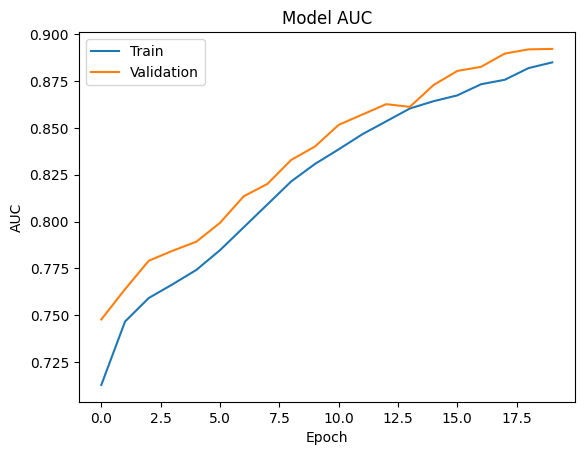

In [79]:
# summarize history for AUC Score
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

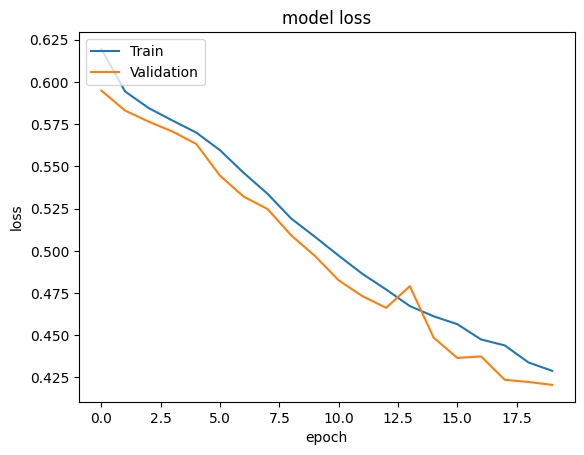

In [80]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [81]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('templet_with_sampling_1_88.50.csv')

#### ⚫ **OBSERVATION:**

▶  In **Trial #1** we notice that when we use **GNN default hyperparameters** the **ROC_AUC_Score** is **88.50%** which is good but maybe the increase in the model complexity of the model will be followed by an increase in performance, and that what will we do in the next trial. 

## III.II) Using GGNN Message-Passing Mechanism

⭐ In the next **3 trials** we will use GGNN Message-Passing Mechanism that is better suited for modeling dynamic graphs, where the structure of the graph changes over time.


### III.II.I) Trial #2 

#### ▶ In **Trial #2**: 
* We will increase the complexity of the model, with **GGNN** **Message-Passing Mechanism**, and increase the number of neurons in the hidden layer to 64 and change defult **exchange_mode** to **mlp**, **num_layers** to **16**, and using **1 Dense** layer which **batch size = 16** and **50 Embedding layer**, may these changes increse the complexity of the model.

In [98]:
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 50)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'], params['global_exchange_mode'] = 64, 'GGNN', 'tanh', 16, 'mlp'

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_2.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [99]:
# Printing GNN default hyperparameters
print(params)

{'aggregation_function': 'sum', 'message_activation_function': 'relu', 'message_activation_before_aggregation': False, 'hidden_dim': 64, 'use_target_state_as_input': False, 'normalize_by_num_incoming': True, 'num_edge_MLP_hidden_layers': 0, 'message_calculation_class': 'GGNN', 'initial_node_representation_activation': 'tanh', 'dense_intermediate_layer_activation': 'tanh', 'num_layers': 16, 'dense_every_num_layers': 2, 'residual_every_num_layers': 2, 'use_inter_layer_layernorm': False, 'layer_input_dropout_rate': 0.0, 'global_exchange_mode': 'mlp', 'global_exchange_every_num_layers': 2, 'global_exchange_weighting_fun': 'softmax', 'global_exchange_num_heads': 4, 'global_exchange_dropout_rate': 0.2}


In [100]:
model_2.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [ ]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history_2 = model_2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

Epoch 1/20
2530/2530 [==============================] - 762s 292ms/step - loss: 0.6649 - auc: 0.6309 - val_loss: 0.6623 - val_auc: 0.6376
Epoch 2/20
2530/2530 [==============================] - 738s 292ms/step - loss: 0.6576 - auc: 0.6480 - val_loss: 0.6605 - val_auc: 0.6405
Epoch 3/20
2530/2530 [==============================] - 797s 315ms/step - loss: 0.6574 - auc: 0.6480 - val_loss: 0.6591 - val_auc: 0.6422
Epoch 4/20
2530/2530 [==============================] - 804s 318ms/step - loss: 0.6560 - auc: 0.6506 - val_loss: 0.6587 - val_auc: 0.6475
Epoch 5/20
2530/2530 [==============================] - 783s 309ms/step - loss: 0.6554 - auc: 0.6513 - val_loss: 0.6549 - val_auc: 0.6531
Epoch 6/20
2530/2530 [==============================] - 808s 319ms/step - loss: 0.6506 - auc: 0.6599 - val_loss: 0.6645 - val_auc: 0.6554
Epoch 7/20
2530/2530 [==============================] - 828s 327ms/step - loss: 0.6498 - auc: 0.6631 - val_loss: 0.6477 - val_auc: 0.6644
Epoch 8/20
2530/2530 [============

In [ ]:
y_pred_2 = model_2.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
print(y_pred_2.shape)
y_pred_2 = np.reshape(y_pred_2, -1)

In [ ]:
# summarize history for AUC Score
plt.plot(history_2.history['auc'])
plt.plot(history_2.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('emb_hid_exch_2_.csv')

#### ⚫ **OBSERVATION:**

▶  In **Trial #2** we notice that the changing the exchange mode from of **gru** to **mip** don't improved the **AUC** Score, but it lead to decreasing the AUC Score to **69.05%**and decreasing the model performance about First Trial.

👉🏻 so we will make some another changes to improve the model performance.

### III.II.II) Trial #3

#### ▶ In **Trial #3**: 
* We will increase the number of Dense layer which we wil add **32 Dense** layer with **RELU** activation function, and we will also increase batch size to 64, may these changes increse the complexity of the model.


In [ ]:
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 50)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = 64, 'GGNN', 'tanh', 16

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

Denlay = Dense(32, activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(Denlay)
print('pred:', pred)

model_3 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_3.summary()

In [ ]:
model_3.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [ ]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history_3 = model_3.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

In [ ]:
y_pred_3 = model_3.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
print(y_pred_3.shape)
y_pred_3 = np.reshape(y_pred_3, -1)

In [ ]:
# summarize history for AUC Score
plt.plot(history_3.history['auc'])
plt.plot(history_3.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_3.csv')

### III.II.III) Trial #4

#### ▶ In **Trial #4**: 
* We will use **RELU** activation function in **dense_intermediate_layer_activation** parameter.


In [ ]:
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 50)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = 64, 'GGNN', 'relu', 16

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

Denlay = Dense(32, activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(Denlay)
print('pred:', pred)

model_4 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_4.summary()

In [ ]:
model_4.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [ ]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history_4 = model_4.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

In [ ]:
y_pred_4 = model_4.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
print(y_pred_4.shape)
y_pred_4 = np.reshape(y_pred_4, -1)

In [ ]:
# summarize history for AUC Score
plt.plot(history_4.history['auc'])
plt.plot(history_4.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_4.csv')

#### ⚫ **OBSERVATION:**

* Overall, we notice that using **GGNN** model it is not working very well with this type of dataset.
* So, We will try to change it and using **RGCN**, may these changes increse the complexity of the model.

## III.III) Using RGCN Message-Passing Mechanism



⭐ In the next **3 trials** we will use **RGCN** Message-Passing Mechanism that is better suited for modeling static graphs, where the structure of the graph remains fixed. RGCNs use convolutional operations to propagate information between nodes based on their structural relationships, but this approach is less effective for modeling dynamic graphs.

⭐ So, I expect that this mechanism will be more accurate in our type of data and it will lead to improve model performance.

### III.III.I) Trial #5




#### ▶ In **Trial #5**: 
* Because of using **GGNN** is not accurate any more with this type of data, so We will use **RGCN** **Message-Passing Mechanism** and sets the output of all message passing layers with size 64 and 8 layers.


In [16]:
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = 64, 'RGCN', 'tanh', 12

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_5 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_5.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [17]:
model_5.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [ ]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history_5 = model_5.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

Epoch 1/20
633/633 [==============================] - 271s 411ms/step - loss: 0.6488 - auc: 0.6620 - val_loss: 0.6250 - val_auc: 0.7098
Epoch 2/20
633/633 [==============================] - 224s 355ms/step - loss: 0.6104 - auc: 0.7199 - val_loss: 0.6081 - val_auc: 0.7306
Epoch 3/20
633/633 [==============================] - 259s 410ms/step - loss: 0.6005 - auc: 0.7336 - val_loss: 0.5950 - val_auc: 0.7390
Epoch 4/20
633/633 [==============================] - 227s 359ms/step - loss: 0.5867 - auc: 0.7499 - val_loss: 0.5820 - val_auc: 0.7587
Epoch 5/20
633/633 [==============================] - 226s 357ms/step - loss: 0.5776 - auc: 0.7596 - val_loss: 0.5655 - val_auc: 0.7744
Epoch 6/20
633/633 [==============================] - 260s 411ms/step - loss: 0.5647 - auc: 0.7764 - val_loss: 0.5592 - val_auc: 0.7860
Epoch 7/20
633/633 [==============================] - 260s 410ms/step - loss: 0.5507 - auc: 0.7923 - val_loss: 0.5446 - val_auc: 0.7988
Epoch 8/20
633/633 [============================

In [ ]:
y_pred_5 = model_5.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
print(y_pred_5.shape)
y_pred_5 = np.reshape(y_pred_5, -1)

In [ ]:
# summarize history for AUC Score
plt.plot(history_5.history['auc'])
plt.plot(history_5.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_5.csv')

### III.III.II) Trial #6


#### ▶ In **Trial #6**: 
* We will increase the number of Dense layer which we wil add **32 Dense** layer with **RELU** activation function, the same parameters in **Trial#3** but using **RGCN** may these changes increse the complexity of the model.

In [ ]:
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = 64, 'RGCN', 'tanh', 8

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

Denlay = Dense(32, activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(Denlay)
print('pred:', pred)

model_6 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_6.summary()

In [ ]:
model_6.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [ ]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history_6 = model_6.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

In [ ]:
y_pred_6 = model_6.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
print(y_pred_6.shape)
y_pred_6 = np.reshape(y_pred_6, -1)

In [ ]:
# summarize history for AUC Score
plt.plot(history_6.history['auc'])
plt.plot(history_6.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_6.csv')

### III.III.III) Trial #7

#### ▶ In **Trial #7**: 
* We will use **RELU** activation function in **dense_intermediate_layer_activation** parameter.

In [ ]:
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = 64, 'RGCN', 'relu', 8

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

Denlay = Dense(32, activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(Denlay)
print('pred:', pred)

model_7 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_7.summary()

In [ ]:
model_7.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [ ]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history_7 = model_7.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

In [ ]:
y_pred_7 = model_7.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
print(y_pred_7.shape)
y_pred_7 = np.reshape(y_pred_7, -1)

In [ ]:
# summarize history for AUC Score
plt.plot(history_7.history['auc'])
plt.plot(history_7.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_7.csv')

#### ⚫ **OBSERVATION:**


* Overall, we notice that using **RGCN** model made the **AUC** Score is **88.03%** which is much better than using **GGNN** with this type of dataset.

## III.IV) Using RGAT Message-Passing Mechanism


⭐ In the next **3 trials** we will use **RGAT** Message-Passing Mechanism that is stands for Relational Graph Attention Network. It is a type of graph neural network that is used for modeling data with complex relational structures, such as social networks or knowledge graphs.

⭐ The RGAT network uses attention mechanisms to aggregate information from the neighboring nodes in a graph, with the attention weights learned during the training process. This allows the model to focus on the most relevant nodes and edges in the graph when making predictions or classifications.

⭐ The RGAT network has been used in various applications, including recommendation systems, natural language processing, and drug discovery. It has been shown to outperform other state-of-the-art graph neural network models in certain tasks, such as link prediction and node classification.


👉🏻 So, let's try it in our dataset and see if it will be more accurate or not.

### III.IV.I) Trial #8

In [ ]:
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = 64, 'RGAT', 'tanh', 12

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model_8 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_8.summary()

In [ ]:
model_8.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [ ]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history_8 = model_8.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

In [ ]:
y_pred_8 = model_8.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
print(y_pred_8.shape)
y_pred_8 = np.reshape(y_pred_8, -1)

In [ ]:
# summarize history for AUC Score
plt.plot(history_8.history['auc'])
plt.plot(history_8.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_8.history['loss'])
plt.plot(history_8.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_8.csv')

### III.IV.II) Trial #9

#### ▶ In **Trial #9**: 
* We will increase the number of Dense layer which we wil add **32 Dense** layer with **RELU** activation function, the same parameters in **Trial#6** but using **RGAT** may these changes increse the complexity of the model.

In [ ]:
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = 64, 'RGAT', 'tanh', 8

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

Denlay = Dense(32, activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(Denlay)
print('pred:', pred)

model_9 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_9.summary()

In [ ]:
model_9.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [ ]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history_9 = model_9.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

In [ ]:
y_pred_9 = model_9.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
print(y_pred_9.shape)
y_pred_9 = np.reshape(y_pred_9, -1)

In [ ]:
# summarize history for AUC Score
plt.plot(history_9.history['auc'])
plt.plot(history_9.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_9.history['loss'])
plt.plot(history_9.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_9.csv')

### III.IV.III) Trial #10

#### ▶ In **Trial #10**: 
* We will use **RELU** activation function in **dense_intermediate_layer_activation** parameter.

In [ ]:
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = 64, 'RGAT', 'relu', 8

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

Denlay = Dense(32, activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(Denlay)
print('pred:', pred)

model_10 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_10.summary()

In [ ]:
model_10.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [ ]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history_10 = model_10.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

In [ ]:
y_pred_10 = model_10.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
print(y_pred_10.shape)
y_pred_10 = np.reshape(y_pred_10, -1)

In [ ]:
# summarize history for AUC Score
plt.plot(history_10.history['auc'])
plt.plot(history_10.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_10.history['loss'])
plt.plot(history_10.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_10.csv')

#### ⚫ **OBSERVATION:**


* Overall, we notice that using **RGAT** model made the **AUC** Score is **81.72%** which is much better than using **GGNN** but using **RGCN** still is the most accurate model with this type of dataset.

## III.V) Using GNN-FILM Message-Passing Mechanism


⭐ In the next trial we will use **GNN-FILM** Message-Passing Mechanism. **GNN-FILM** mechanism modulates the weight matrix based on the node's own features, allowing for more flexible and adaptive updates.

⭐ The **GNN-FILM** mechanism has been shown to improve the performance of graph neural networks on various tasks, including node classification and link prediction. It allows for more expressive and adaptive updates to the node activations, allowing the model to better capture the complex relationships between nodes in a graph.

### III.V.I) Trial #11

In [ ]:
from tf2_gnn.layers.gnn import GNN, GNNInput

keras.backend.clear_session()

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] ,params['message_calculation_class'], params['dense_intermediate_layer_activation'], params['num_layers'] = 64, 'GNN-FILM', 'tanh', 8

gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

Denlay = Dense(32, activation='relu')(avg)
pred = Dense(1, activation='sigmoid')(Denlay)
print('pred:', pred)

model_11 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model_11.summary()

In [ ]:
model_11.compile(
    loss='BinaryCrossentropy',
    optimizer = Adam(),
    metrics=['AUC']
)

In [ ]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(training_set) / batch_size)

early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode = 'max')

history_11 = model_11.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=batch_size, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks=[early_stopping]
)

In [ ]:
y_pred_11 = model_11.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
print(y_pred_11.shape)
y_pred_11 = np.reshape(y_pred_11, -1)

In [ ]:
# summarize history for AUC Score
plt.plot(history_11.history['auc'])
plt.plot(history_11.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history_11.history['loss'])
plt.plot(history_11.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# define function to save the csv file of the result after each trial
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('trial_11.csv')

#### ⚫ **OBSERVATION:**


* Overall, we notice that using **RGCN** model is much better than using **GGNN**, **RGAT** and **GNN-FILM** with this type of dataset.



---



---



# Part IV) Answering the Questions 😃

## 🌈 **Q1:** Based on the provided template, describe the format of the input file (sdf file).

☘️ In general, The SDF (Structure Data File) format is a standard file format used for storing and exchanging information about chemical structures. SDF files are commonly used in the field of drug discovery and chemistry to store information about molecular structures and properties.

☘️ The SDF file format is a plain text format that consists of a series of records, with each record containing information about a single molecule. The records are separated by blank lines, and each record consists of a series of lines that describe different aspects of the molecule.

👉🏻 In the Anti-Cancer Drug Activity Prediction task, the input file format is an SDF (Structure Data File) format that contains information about the molecular structures and features of different chemical compounds. Specifically, the SDF file format includes the following information:

⭐ The molecular structure of each compound, represented by a series of atoms and bonds.

⭐ A set of molecular fingerprints or features, which are binary values that represent the presence or absence of certain chemical substructures or properties in the compound.

⭐ A label indicating the activity of the compound against a specific type of cancer or multiple types of cancer. The label can either be a binary value (active or inactive) or a continuous value (IC50 value), depending on the specific task.



---



---



## 🌈 **Q2:** What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

🔥 **Batch_Size**: refers to the number of training examples used in a single iteration of the training process. It is a hyperparameter that defines the number of samples that are processed before the model's parameters are updated based on the gradients of the loss function. The dimension of the batch_size is **1D**.


🔥 **input_1:** An input layer that takes a **1D** tensor of integer values as input. This input represents the node features of the graph and has a shape of **(None,)**, where None indicates that the input can have variable length.

🔥 **input_2**: An input layer that takes a **2D** tensor of integer values as input. This input represents the edge indices of the graph and has a shape of **(None, 2)**, where None indicates that the input can have variable length and 2 indicates that each edge index is represented as a pair of integers.

🔥 **input_3**: An input layer that takes a **1D** tensor of integer values as input. This input represents the graph indices to which each node belongs and has a shape of **(None,)**, where None indicates that the input can have variable length.




---



---



## 🌈 **Q3:** For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

☘️ The gnn out has the shape (batch_size*max_nodes_per_graph,hidden_dim), the first dim here represents the number of features for each node (node2graph), where the hidden_dim here is the size of the output of all message passing layers.

☘️ avg: The output of gnn_out is(batch_size*max_nodes_per_graph, hidden layers) for each sample in the batch size. Each sample is assigned a unique segment_id. As a result, segment_mean takes the average of all the data in the gnn_out output and represents one sample with one integer for each hidden layer. The average tensor's final output is of the form (batch_size, hidden_dim). It is a method of gathering information for each sample and portraying it as mean data.



---



---



## 🌈 **Q4:** What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

👉🏻 Both tf.math.segment_mean and tf.reduce_mean are TensorFlow functions for computing the mean of a tensor along a specific axis. However, they differ in how they handle tensors that have segments or groups.

⭐ **tf.reduce_mean** computes the mean of the entire tensor along a specific axis, without considering any segmentation or grouping. For example, **tf.reduce_mean(x, axis=0)** would compute the mean of x along the first dimension, without considering any segments or groups.

⭐ **tf.math.segment_mean,** on the other hand, computes the mean of each segment or group along a specific axis. It expects an additional tensor segment_ids that specifies the segment or group to which each element in the input tensor belongs. For example, **tf.math.segment_mean(x, segment_ids, axis=0)** would compute the mean of each segment in x along the first dimension, where the segments are defined by the corresponding values in segment_ids.





---



---



## 🌈 **Q5:** What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

⭐ In a single GCN layer, the model applies a graph convolution operation to the node features in the input graph, which produces a new set of node features that incorporate information from the neighboring nodes in the graph. However, this operation only captures local dependencies and may not fully capture the global structure of the graph.

⭐ By stacking multiple GCN layers, the model can learn more complex representations of the input graph by recursively combining the features learned in the previous layer with the updated node features from the current layer. This allows the model to capture both local and global dependencies in the graph, and learn hierarchical representations that can be used for downstream tasks such as node classification or graph classification.

👉🏻 The number of layers used in the template was the default number which is **4 layers.**